In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

# Funciones para crear los datos y para dibujar

In [2]:
def rota_datos_alrededor_origen(X, angulo):
    angle_rad = angulo*2.0*np.pi/360.0

    s = np.sin(angle_rad)
    c = np.cos(angle_rad)
    matriz_rotacion = np.array([[c,-s],[s,c]])
    X_rotados = np.dot(matriz_rotacion, X) # se rotan los puntos generados

    return X_rotados

In [3]:
def genera_puntos_gausiana2D(Npuntos, media, var1, var2, angulo, display):
    X = np.random.randn(2, Npuntos)
    X[0,:] = X[0,:] * np.sqrt(var1) # se multiplica cada atributo por la
    X[1,:] = X[1,:] * np.sqrt(var2) # raiz cuadrada de la varianza deseada

    X = rota_datos_alrededor_origen(X, angulo)

    X[0,:] = media[0] + X[0,:]
    X[1,:] = media[1] + X[1,:]

    # Display
    if display:
        plt.figure(1)
        plt.plot(X[0,:],X[1,:],'bo',zorder=1)
        plt.grid(True)
        plt.axis('equal')
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.show()

    return X

## Generación de los datos del problema:

In [4]:
# Number of samples per component:
n_samples = 200

# Generate random sample, three components:
X1 = genera_puntos_gausiana2D(n_samples, [0, 0], 1, 1, 45, False)
X2 = genera_puntos_gausiana2D(n_samples, [10, 0], 8, 1, 45, False)
X3 = genera_puntos_gausiana2D(n_samples, [5, 5], 4, 1, 0, False)
X = np.concatenate((X1, X2, X3), axis=1).transpose()
Y = np.array([0] * n_samples + [1] * n_samples + [2] * n_samples)

print(X.shape, Y.shape)

(600, 2) (600,)


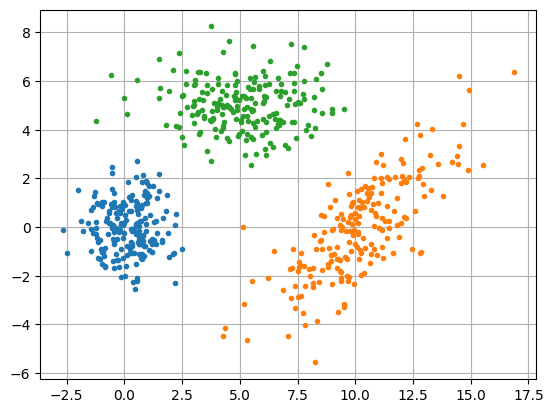

In [5]:
plt.figure()
for c in np.unique(Y):
  plt.plot(X[Y==c, 0], X[Y==c, 1], '.')
plt.grid(True)
plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Entrenamiento con SVMs

### SVM Lineal

En primer lugar, vamos a probar una SVM lineal.

In [58]:
svm = SVC(C=1.0, kernel="linear", probability=True)
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

1.0

In [59]:
xx, yy = np.meshgrid(np.arange(X[:, 0].min()-0.5, X[:, 0].max()+0.5, 0.1), np.arange(X[:, 1].min()-0.5, X[:, 1].max()+0.5, 0.1))
xy = np.vstack([xx.ravel(), yy.ravel()]).T

p = svm.predict_proba(xy)

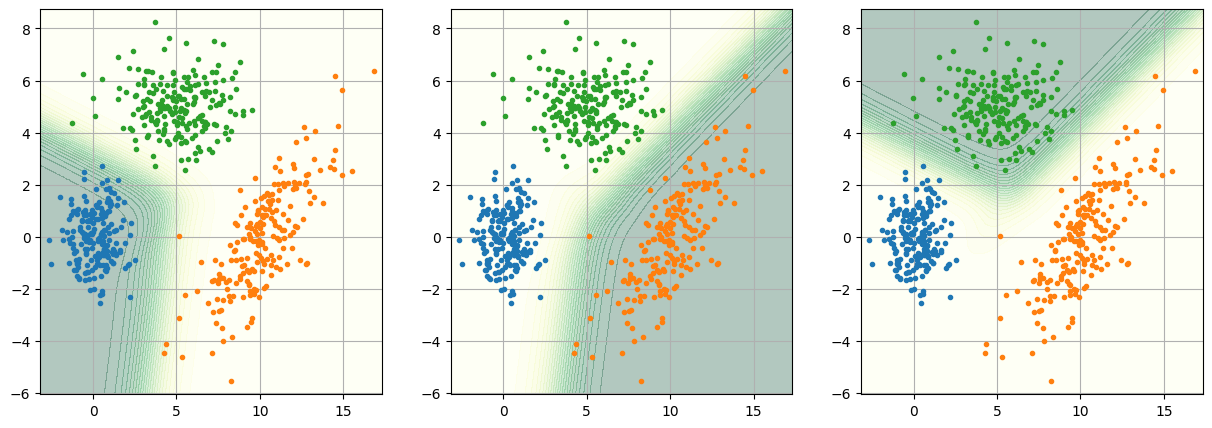

In [60]:
plt.figure(figsize=(15, 5))
for c in np.unique(Y):
  zz = p[:, c].reshape(xx.shape)
  levels = np.linspace(0, zz.max(), 25)

  plt.subplot(1,3,c+1)
  plt.contourf(xx, yy, zz, levels=levels, cmap="YlGn", alpha=0.3)
  for cl in np.unique(Y):
    plt.plot(X[Y==cl, 0], X[Y==cl, 1], '.')

  plt.grid()
plt.show()

**¿Qué está pasando?**

¿Cómo hemos podido ejecutar una SVM para un problema de 3 clases?

Por defecto, las SVMs usan también la estrategia 'ovr' (**One vs Rest**). Esto significa que va a construir un modelo para separar cada una de las clases de forma individual.

Sin embargo, **por defecto no podemos acceder a cada modelo individual**. Hay que hacer un wrapper para construirlos individualmente y comprobar cómo funcionan.

In [61]:
model = OneVsRestClassifier(SVC(C=1.0, kernel="linear", probability=True))
model.fit(X_train, y_train)
model.score(X_test, y_test)

1.0

In [62]:
model.estimators_ # Esta variable guarda cada modelo

[SVC(kernel='linear', probability=True),
 SVC(kernel='linear', probability=True),
 SVC(kernel='linear', probability=True)]

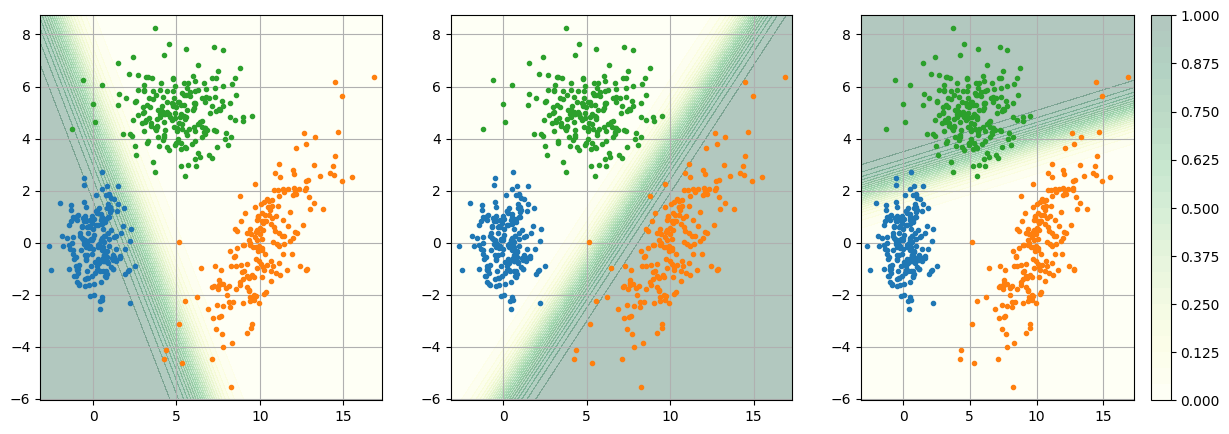

In [63]:

plt.figure(figsize=(15, 5))
for c in np.unique(y_train):
  p = model.estimators_[c].predict_proba(xy)[:, 1]
  zz = p.reshape(xx.shape)
  levels = np.linspace(0, zz.max(), 25)

  plt.subplot(1,3,c+1)
  plt.contourf(xx, yy, zz, levels=levels, cmap="YlGn", alpha=0.3)
  for cl in np.unique(Y):
    plt.plot(X[Y==cl, 0], X[Y==cl, 1], '.')

  plt.grid()
plt.colorbar()
plt.show()

### SVM con Kernel Polinomico

Ahora vamos a probar el Kernel polinómico. Probemos con diferentes grados.

In [86]:
degree = 4

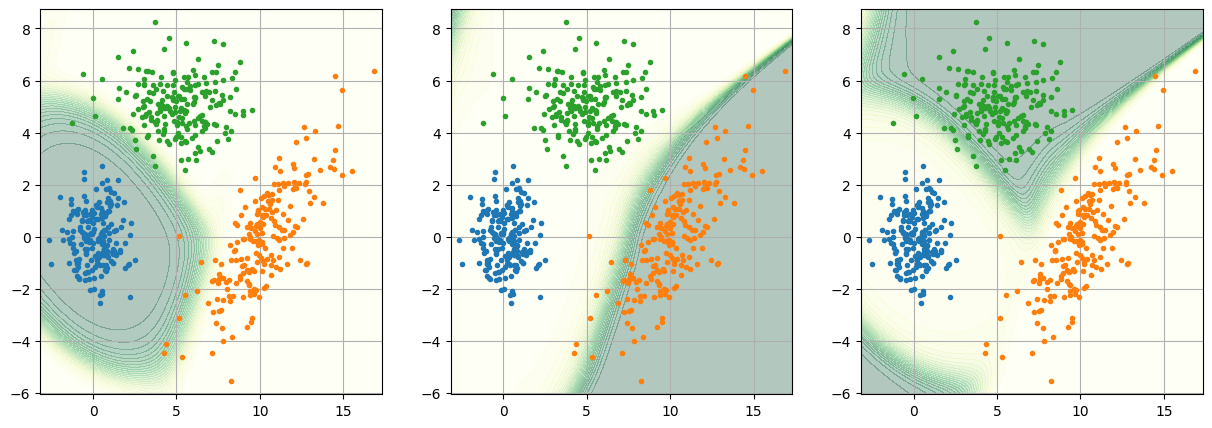

In [87]:
svm = SVC(C=1.0, kernel="poly", degree=degree, probability=True)
svm.fit(X_train, y_train)

xx, yy = np.meshgrid(np.arange(X[:, 0].min()-0.5, X[:, 0].max()+0.5, 0.1), np.arange(X[:, 1].min()-0.5, X[:, 1].max()+0.5, 0.1))
xy = np.vstack([xx.ravel(), yy.ravel()]).T
p = svm.predict_proba(xy)

plt.figure(figsize=(15, 5))
for c in np.unique(Y):
  zz = p[:, c].reshape(xx.shape)
  levels = np.linspace(0, zz.max(), 25)

  plt.subplot(1,3,c+1)
  plt.contourf(xx, yy, zz, levels=levels, cmap="YlGn", alpha=0.3)
  for cl in np.unique(Y):
    plt.plot(X[Y==cl, 0], X[Y==cl, 1], '.')

  plt.grid()
plt.show()

### SVM con Kernel RBF

Ahora vamos a probar con el Kernel RBF. Probemos diferentes gamma.

In [96]:
gamma = 0.01

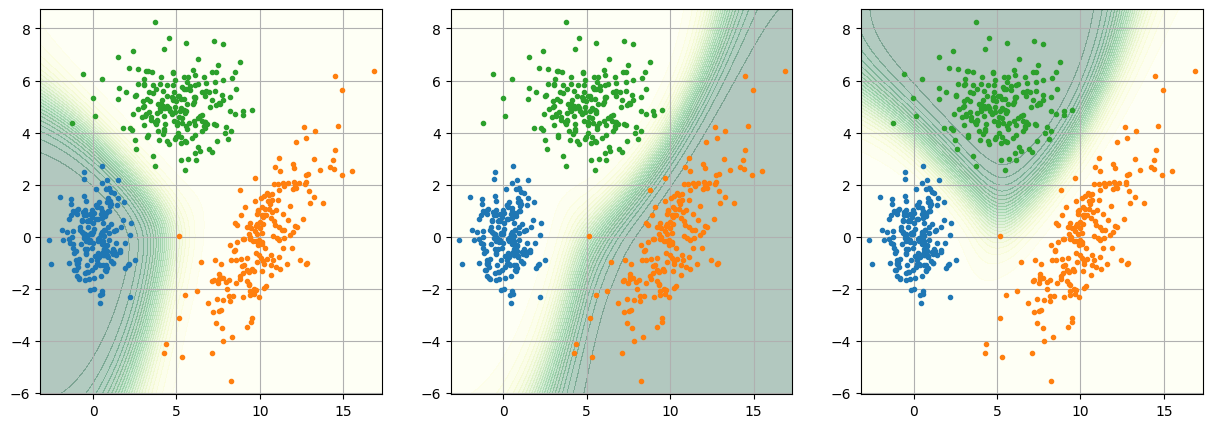

In [97]:
svm = SVC(C=1.0, kernel="rbf", gamma=gamma, probability=True)
svm.fit(X_train, y_train)

xx, yy = np.meshgrid(np.arange(X[:, 0].min()-0.5, X[:, 0].max()+0.5, 0.1), np.arange(X[:, 1].min()-0.5, X[:, 1].max()+0.5, 0.1))
xy = np.vstack([xx.ravel(), yy.ravel()]).T
p = svm.predict_proba(xy)

plt.figure(figsize=(15, 5))
for c in np.unique(Y):
  zz = p[:, c].reshape(xx.shape)
  levels = np.linspace(0, zz.max(), 25)

  plt.subplot(1,3,c+1)
  plt.contourf(xx, yy, zz, levels=levels, cmap="YlGn", alpha=0.3)
  for cl in np.unique(Y):
    plt.plot(X[Y==cl, 0], X[Y==cl, 1], '.')

  plt.grid()
plt.show()